In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
from scipy.stats import entropy, zscore,  pearsonr,spearmanr, linregress
import scipy.spatial.distance as scist
import csv
import konlpy
nlp_tagger = konlpy.tag.Okt()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

event_segmentation = pd.read_csv('utils/movie_event_segmentation.csv')

n_events = len(event_segmentation)
event_times = []
for event in range(n_events):
    event_times.append(np.arange(event_segmentation['on time'][event], event_segmentation['off time'][event], 2))

event_dict = {}
for event in range(n_events):
    for time in event_times[event]:
        event_dict[time] = event

event_words = {}
for event in range(n_events):
    event_words[event] = []

for event in range(n_events):
    try:
        for word in event_segmentation['dictionary'][event].split():
            event_words[event].append(word)
    except:
        pass

movie_user_dictionary = pd.read_csv('utils/movie_user_dictionary.csv')
user_dictionary = {}
before_words = []
for i in range(len(movie_user_dictionary)):
    before_word = movie_user_dictionary['before'][i]
    after_word = movie_user_dictionary['after'][i]
    user_dictionary[before_word] = after_word
    before_words.append(before_word)


In [2]:
movie_annotation = 'utils/movie_korean_annotation.csv'
passed_pos = ['Noun', 'Verb']
num_cols=4

# Use example parameters for schematic figure 2A
window_size_ref = 5
num_topic = 50
window_size_recall = 5

ref_words = []
with open(movie_annotation, 'r', encoding="utf-8") as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        data = []
        current_event = event_dict[int(row[0])]
        for col in range(num_cols):
            for word, pos in nlp_tagger.pos(row[2+col], stem=True):
                if pos in passed_pos:
                    data.append(word)
        ref_words.append(' '.join([word for word in data] + event_words[current_event]))


ref_words_ngram = []
for i in range(len(ref_words)):
    if i < window_size_ref:
        ref_words_ngram.append(' '.join(ref_words[0:i + window_size_ref+1]))
    else:
        ref_words_ngram.append(' '.join(ref_words[i-window_size_ref:i + window_size_ref+1]))
mrbean_ref = np.array(ref_words_ngram)

np.random.seed(0) #for reproducibility

countvector_model = CountVectorizer().fit(mrbean_ref)
lda_model = LatentDirichletAllocation(n_components=num_topic,
                                      learning_method='batch')
lda_model.fit(countvector_model.transform(mrbean_ref))

ref_model = lda_model.transform(countvector_model.transform(mrbean_ref))
ref_pd = np.nansum((1 - scist.cdist(ref_model, ref_model, 'cosine')), axis=1)


recall_models = []
recall_matrices = []
for subject in subjects:
    recall_fname = f'utils/behavioral_data/{subject}_recall.txt'
    recall_words = []
    recall_sents = []
    with open(recall_fname, 'r', encoding='utf-8') as file:
        for line in file.readlines():
            bow = []
            for word, pos in nlp_tagger.pos(line, stem=True):
                if pos in passed_pos:
                    if word in before_words:
                        bow.append(user_dictionary[word])
                        recall_words.append(user_dictionary[word])
                    else:
                        bow.append(word)
                        recall_words.append(word)
            recall_sents.append(' '.join([word for word in bow]))

    mrbean_recall = []
    for i in range(len(recall_sents)):
        if i < window_size_recall:
            mrbean_recall.append(' '.join(recall_sents[0:i + window_size_recall+1]))
        else:
            mrbean_recall.append(' '.join(recall_sents[i-window_size_recall:i + window_size_recall+1]))

    recall_model = lda_model.transform(countvector_model.transform(mrbean_recall))
    recall_models.append(recall_model)
    recall_matrices.append(1 - scist.cdist(ref_model, recall_model, 'cosine'))

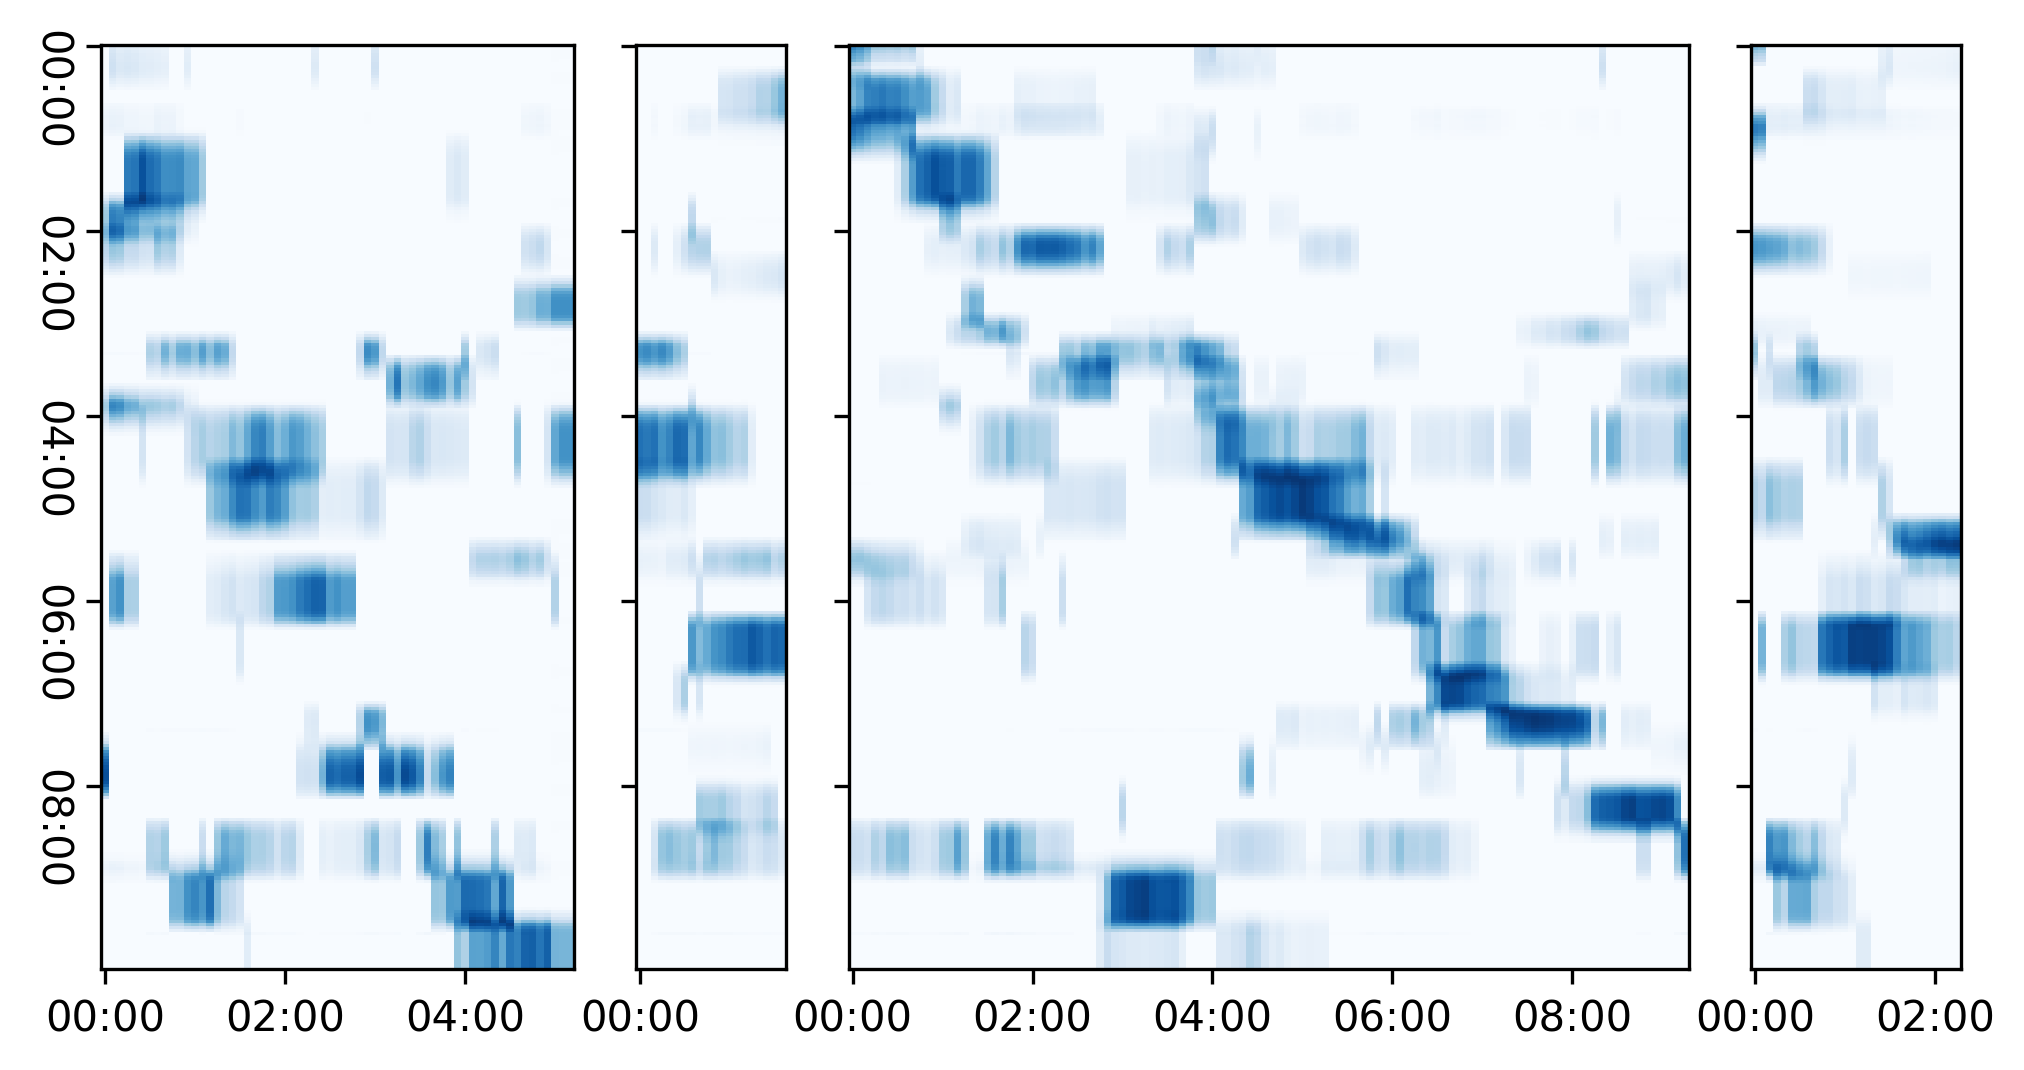

In [3]:
def get_timeformat(seconds):
    m, s = divmod(seconds, 60)
    string = f'{m:02d}:{s:02d}'
    return string

subject_to_plot = [36,55,3,15] # 4 example subjects

fig, axes = plt.subplots(1,len(subject_to_plot),figsize=(8, 4),dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[recall_matrices[s].shape[1] for s in subject_to_plot]})
for i, s in enumerate(subject_to_plot):
    axes[i].imshow(recall_matrices[s], aspect='auto',cmap='Blues', vmin=0, vmax=1)
    tick_list = np.arange(0,recall_matrices[s].shape[1], 24)
    axes[i].set_xticks(tick_list)
    axes[i].set_xticklabels([get_timeformat(i*5) for i in tick_list])

tick_list = [0, 60, 120, 180, 240]
axes[0].set_yticks(tick_list)
axes[0].set_yticklabels([get_timeformat(i*2) for i in tick_list], rotation=270)
plt.subplots_adjust(wspace=0.15)

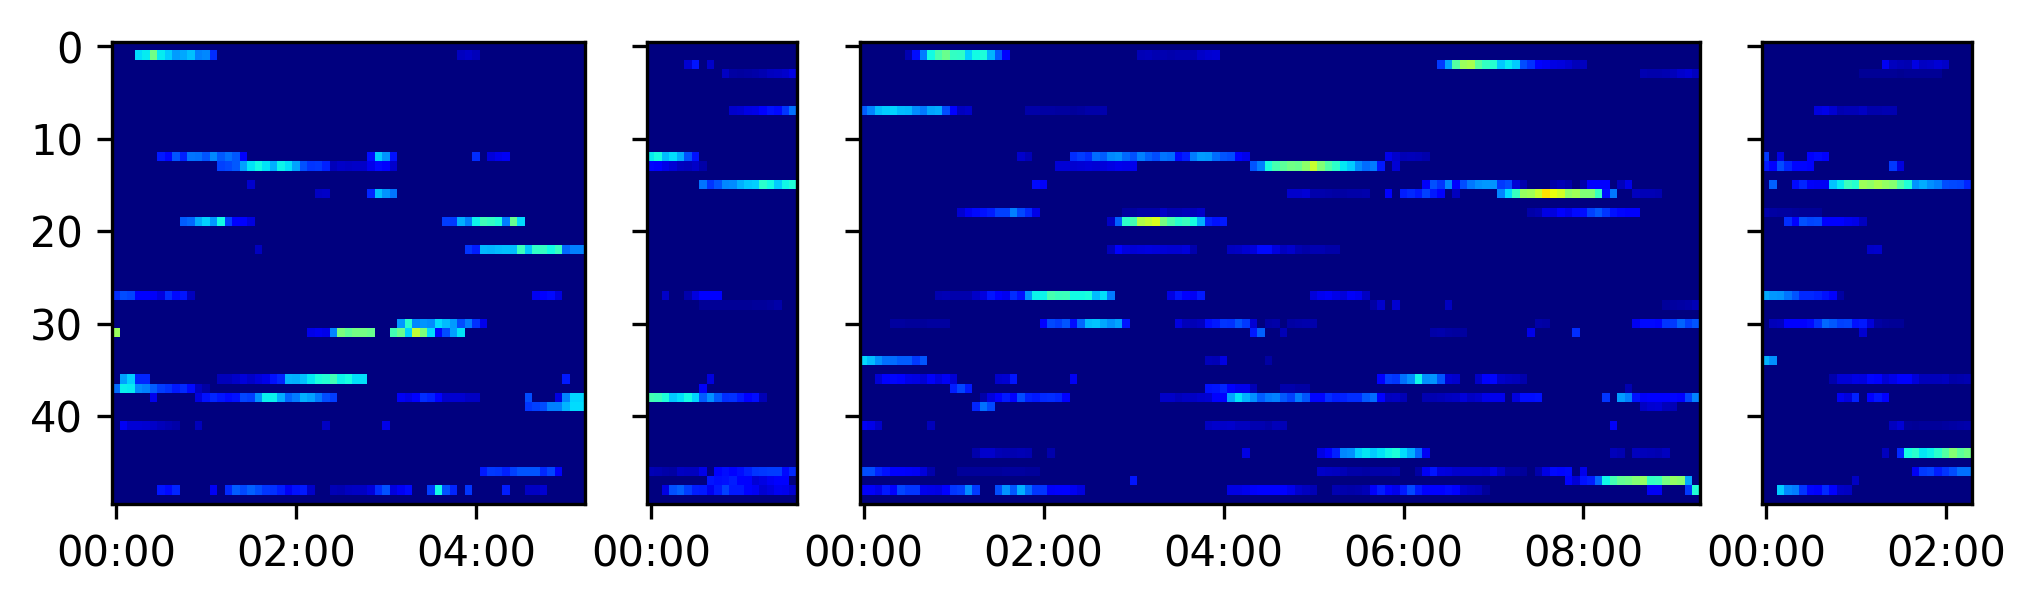

In [4]:
subject_to_plot = [36,55,3,15]

fig, axes = plt.subplots(1,len(subject_to_plot),figsize=(8, 2),dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[recall_models[s].shape[0] for s in subject_to_plot]})
for i, s in enumerate(subject_to_plot):
    axes[i].imshow(recall_models[s].T, aspect='auto',cmap='jet', vmin=0.0, vmax=1.0)
    tick_list = np.arange(0,recall_models[s].shape[0], 24)
    axes[i].set_xticks(tick_list)
    axes[i].set_xticklabels([get_timeformat(i*5) for i in tick_list])
plt.subplots_adjust(wspace=0.15)

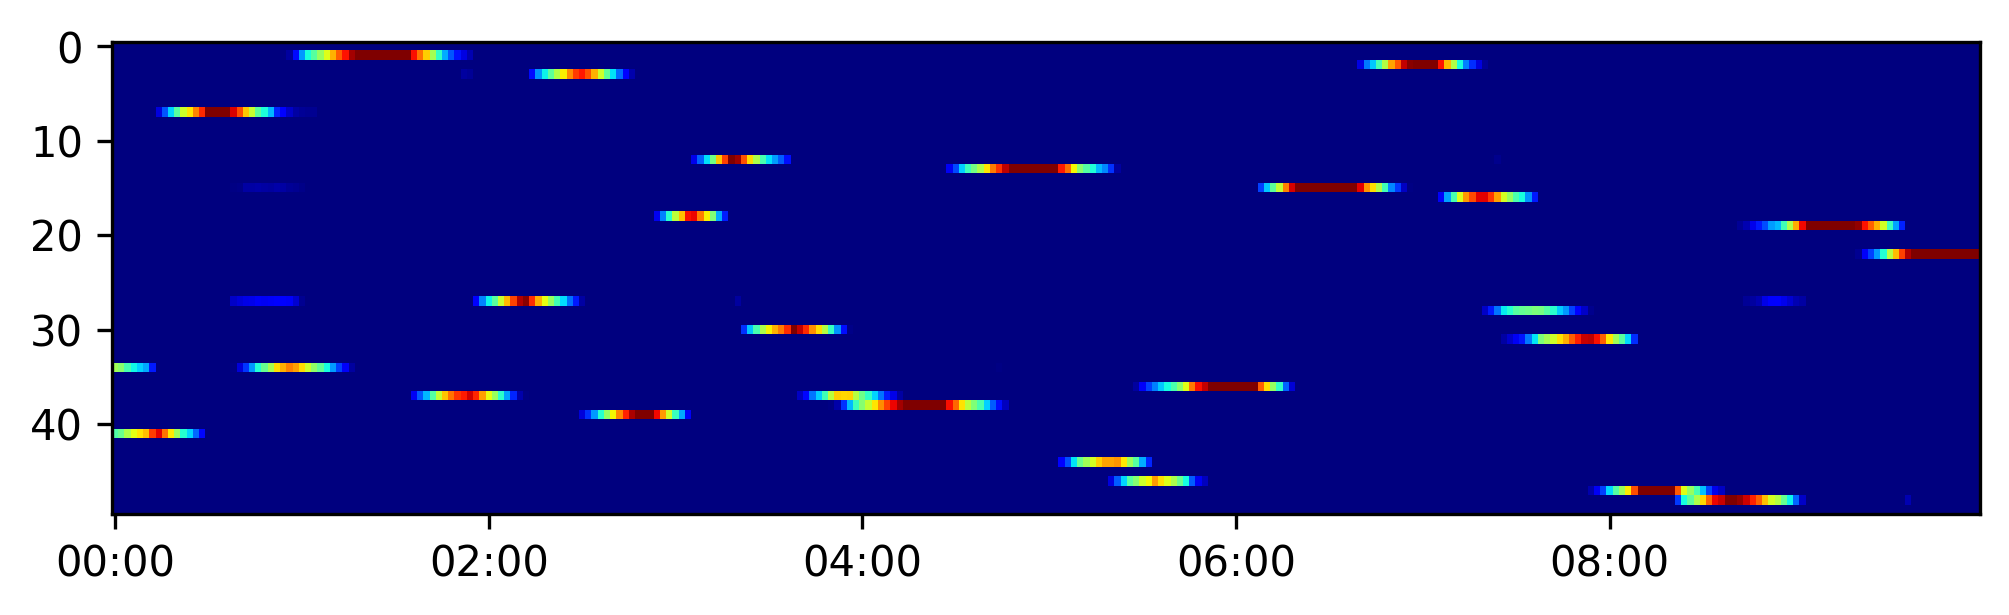

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6.8, 2.15),dpi=300)
ax.imshow(ref_model.T, aspect='auto',cmap='jet', vmin=0.0, vmax=1.0)
tick_list = [0, 60, 120, 180, 240]
ax.set_xticks(tick_list)
ax.set_xticklabels([get_timeformat(i*2) for i in tick_list])
plt.tight_layout()

[Text(0, 0, '00:00'),
 Text(0, 60, '02:00'),
 Text(0, 120, '04:00'),
 Text(0, 180, '06:00'),
 Text(0, 240, '08:00')]

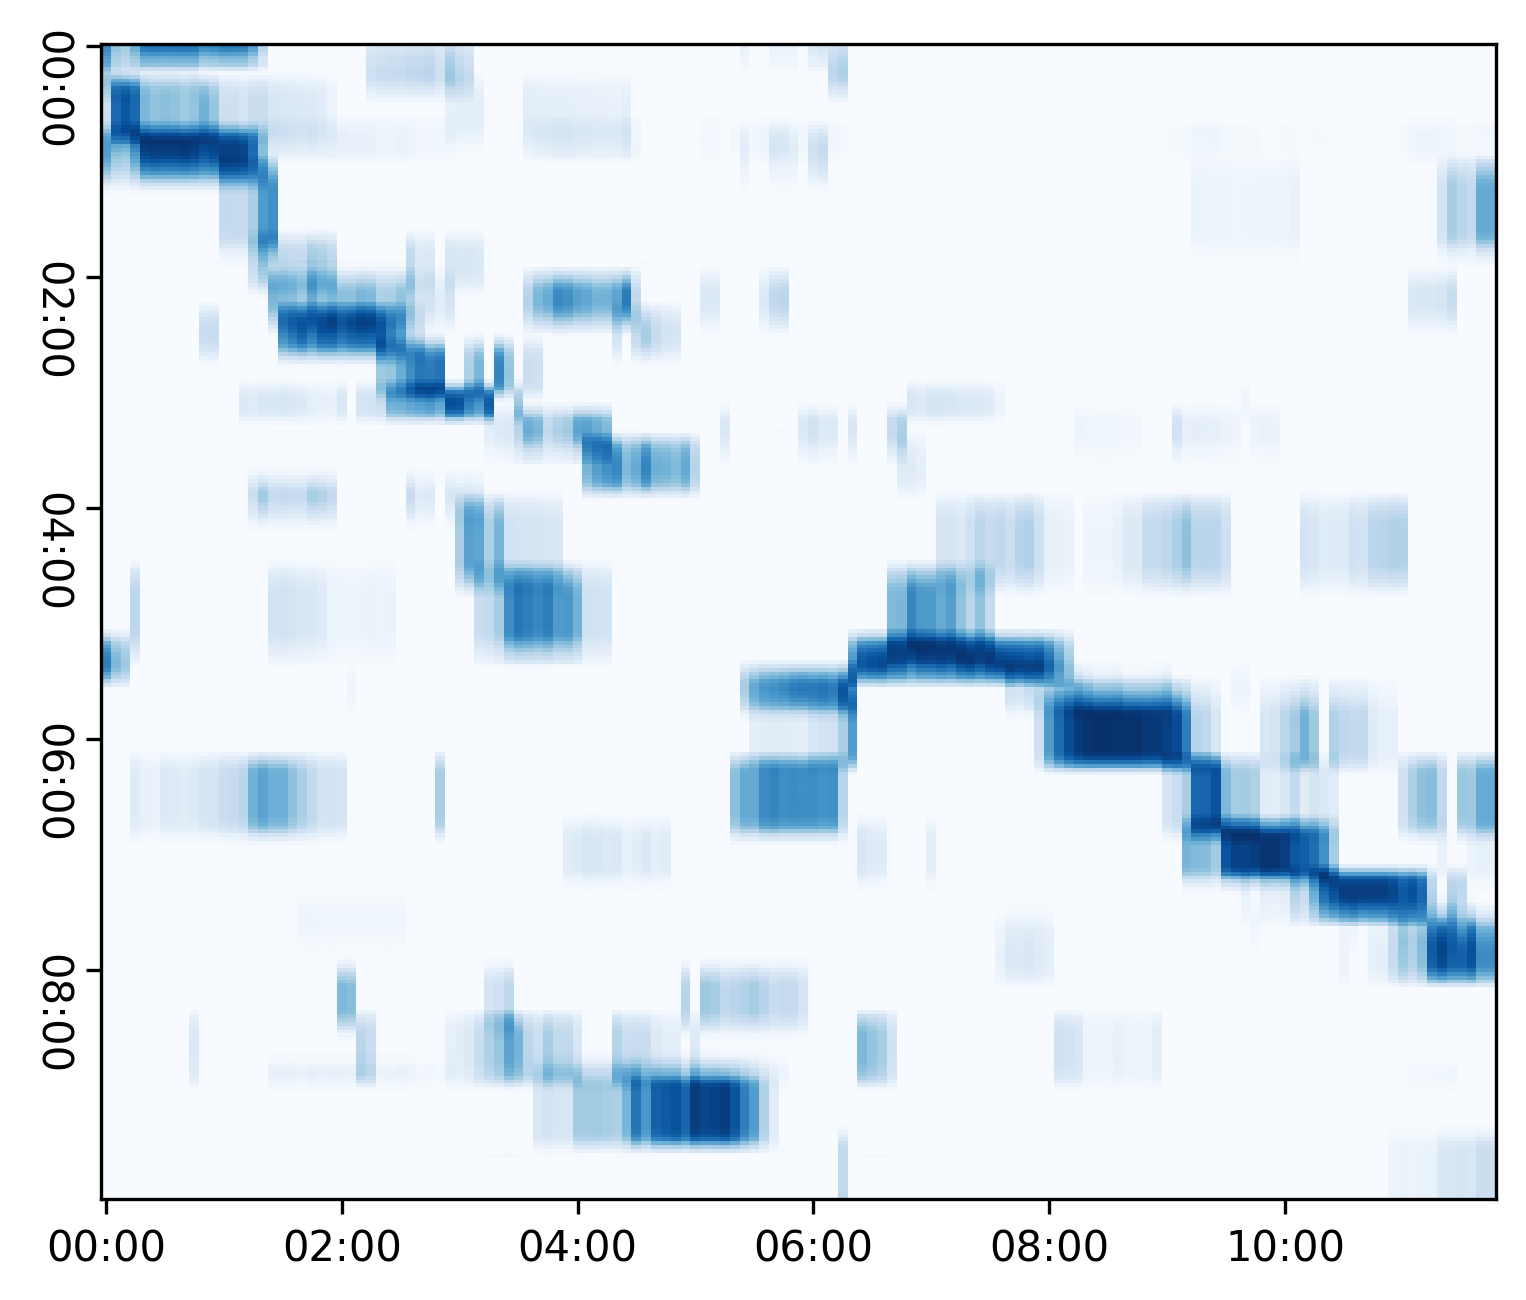

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6, 5),dpi=300)

ax.imshow(recall_matrices[6], aspect='auto',cmap='Blues', vmin=0, vmax=1)
tick_list = np.arange(0,recall_matrices[6].shape[1], 24)
ax.set_xticks(tick_list)
ax.set_xticklabels([get_timeformat(i*5) for i in tick_list])
tick_list = [0, 60, 120, 180, 240]
ax.set_yticks(tick_list)
ax.set_yticklabels([get_timeformat(i*2) for i in tick_list], rotation=270)


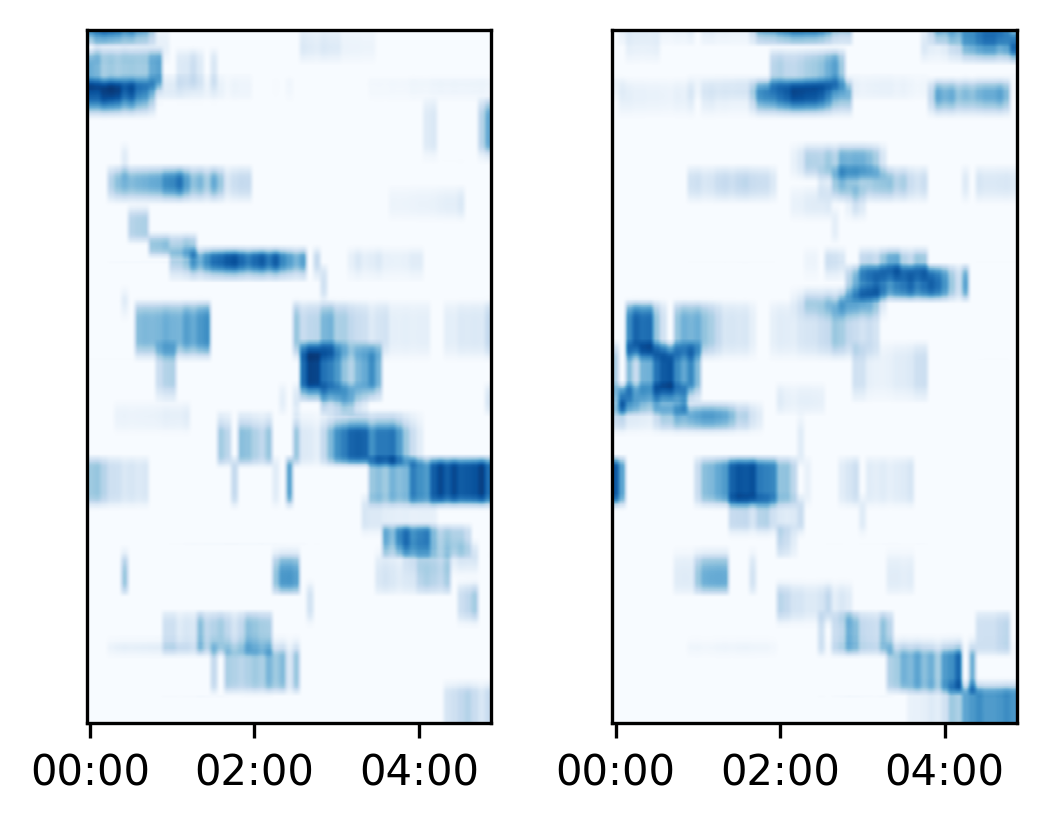

In [7]:
subject_to_plot = [54, 60] # 2 example subjects

fig, axes = plt.subplots(1,len(subject_to_plot),figsize=(4, 3),dpi=300,
                         gridspec_kw={'width_ratios':[recall_matrices[s].shape[1] for s in subject_to_plot]})
for i, s in enumerate(subject_to_plot):
    axes[i].imshow(recall_matrices[s], aspect='auto',cmap='Blues', vmin=0, vmax=1)
    tick_list = np.arange(0,recall_matrices[s].shape[1], 24)
    axes[i].set_xticks(tick_list)
    axes[i].set_xticklabels([get_timeformat(i*5) for i in tick_list])
    axes[i].set_yticks([])

plt.subplots_adjust(wspace=0.3)
